In [1]:
import gym
import pandas as pd
import numpy as np
from datetime import timedelta
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
df = pd.read_csv("data/Blue and fin whales Southern California 2014-2015 - Fastloc GPS data.csv")

In [3]:
df = df[df['manually-marked-outlier'].isna()] # 19 outliers sur 17169 points
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [4]:
whales = []
for id in df['individual-local-identifier'].unique():
    whales.append(df[df['individual-local-identifier']==id][['timestamp','location-lat','location-long']])

In [32]:
dt_min = []
dt_mean = []
for i in range(len(whales)):
    diff = whales[i]['timestamp'].diff()/np.timedelta64(1, 'm')
    dt_min.append(diff.min())
    dt_mean.append(diff.mean())

In [39]:
dt = '1min'
secdt = int(dt[:-3])*60
datas = []
for whale in whales:
    data = whale.set_index('timestamp').resample(dt).mean().interpolate(method='polynomial',order=2)
    print('ok')
    data['daycos'] = data.apply(lambda r: np.cos((r.name.timestamp() - r.name.to_period('D').to_timestamp().timestamp())*2*np.pi/86400), axis=1)
    data['yearcos'] = data.apply(lambda r: np.cos((r.name.timestamp() - r.name.to_period('Y').to_timestamp().timestamp())*2*np.pi/31536000), axis=1)
    datas.append(data)

ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok


In [134]:
feat = 'location-lat'
delta = df[feat].max() - df[feat].min()
df[feat].min() - delta*0.01, df[feat].max() + delta*0.01

(30.958211, 40.545089)

In [178]:
delta_max = []
for data in datas:
    diff = data.diff()
    diff['dist'] = np.sqrt(diff['location-lat']**2 + diff['location-long']**2)
    delta_max.append(diff['dist'].max())

In [179]:
delta_max

[0.001911890033929598,
 0.002771656044543397,
 0.013210197289478738,
 0.011953535213699386,
 0.012299354340765144,
 0.003103413280324436,
 0.0025641055029075937,
 0.002787762297692037,
 0.0019919571735497027,
 0.000990308718035042,
 0.0035022461704757105,
 0.0011196267355189735,
 0.0025875999983936125]

In [180]:
max(delta_max)*np.sqrt(2)

0.01868204016840513

In [82]:
dlat = []
dlong = []
for data in datas:
    diff = data.diff()
    dlat += list(diff['location-lat'])[1:]
    dlong += list(diff['location-long'])[1:]


In [91]:
np.quantile(dlat,0.999)

0.0013142668765637857

<AxesSubplot:ylabel='Count'>

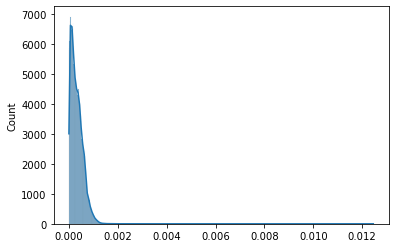

In [99]:
sns.histplot(abs(np.array(dlat)),kde=True)

In [102]:
df['individual-local-identifier'].unique()[0]

'2014CA-Bmu-05644'

In [5]:
class Ocean(gym.Env):
    """Custom Environment that follows gym interface"""
    metadata = {'render.modes': ['human']}

    def __init__(self, num=None):
        
        super(Ocean, self).__init__()    
        
        # Define delta space and time
        self.ds = 0.018 # degrees (around 333m)
        self.dt = timedelta(minutes=1)
        
        self._load_data(num)

        # Define 5 actions LEFT, RIGHT, UP, DOWN, NONE
        self.action_space = gym.spaces.Discrete(5)

        # Define observation space as latitude, longitude, daycos, yearcos
        self.observation_space = gym.spaces.Box(low=np.array((31,-125,-1,-1)), high=np.array((41,-116,1,1)), dtype=np.float16)
        
        # Set first state
        self.reset()

        
    def _load_data(self, num):
        
        df = pd.read_csv("data/Blue and fin whales Southern California 2014-2015 - Fastloc GPS data.csv")
        df = df[df['manually-marked-outlier'].isna()]
        ids = df['individual-local-identifier'].unique()
        if num==None:
            num = np.random.randint(len(ids))
        id = ids[num]
        data = df[df['individual-local-identifier']==id][['timestamp','location-lat','location-long']] 
        data['timestamp'] = pd.to_datetime(data['timestamp'])
        data = data.set_index('timestamp').resample(self.dt).mean().interpolate(method='polynomial',order=2)
        data['daycos'] = data.apply(lambda r: np.cos((r.name.timestamp() - r.name.to_period('D').to_timestamp().timestamp())*2*np.pi/86400), axis=1)
        data['yearcos'] = data.apply(lambda r: np.cos((r.name.timestamp() - r.name.to_period('Y').to_timestamp().timestamp())*2*np.pi/31536000), axis=1)
        
        self.data = data
        
    def step(self, action):
        # Execute one time step within the environment
        self.iter += 1
        
        if action == 1:
            self.state[1] -= self.ds
        elif action == 2:
            self.state[1] += self.ds
        elif action == 3:
            self.state[0] += self.ds
        elif action == 4:
            self.state[0] -= self.ds
            
        self.state[2] = self.data['daycos'].iloc[self.iter]
        self.state[3] = self.data['yearcos'].iloc[self.iter]
        
        reward = self.square_reward()
        
        done = False
        if reward >= 1 :
            done = True
        
        return np.array(self.state), reward, done, {}


    def reset(self):
        self.state = np.array(self.data.iloc[0])
        self.iter = 0
    
    def square_reward(self):
        return (self.state[0] - self.data['location-lat'].iloc[self.iter])**2 + (self.state[1] - self.data['location-long'].iloc[self.iter])**2
        
    def render(self, mode='human', close=False):
        # Render the environment to the screen
        plt.figure('render')
        plt.scatter(self.state[1],self.state[0],c='b')
        plt.scatter(self.data['location-long'].iloc[self.iter],self.data['location-lat'].iloc[self.iter],c='r')
        plt.pause(0.01)

In [6]:
env = Ocean(4)
env.reset()


C:\Users\bapti\anaconda3\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [7]:
env.reset()
for i in range(10000):
    _, reward, done, _ = env.step(np.random.randint(5))
    if done:
        print(i)
        break

898


In [8]:
%matplotlib

Using matplotlib backend: Qt5Agg


In [8]:
import ray
from ray.rllib import agents

ray.init()
trainer = agents.dqn.DQNTrainer(env='Ocean')

Instructions for updating:
non-resource variables are not supported in the long term


ConnectionError: Error 10060 connecting to 192.168.100.100:6379. Une tentative de connexion a échoué car le parti connecté n’a pas répondu convenablement au-delà d’une certaine durée ou une connexion établie a échoué car l’hôte de connexion n’a pas répondu.